# Task 3 - Feature Matching using SIFT

Write a function which takes an image from the same dataset for training
and testing as in the previous task.

**Main steps:**
1. You first extract keypoints and feature descriptors from your
Test and Train images using standard SIFT or SURF feature extraction
function from a library.
2. Then you match features between images which will give you the raw noisy matches (correspondences).
3. Now you should decide which geometric transform to use to reject the outliers. (using RANSAC)
4. Finally, you will
define a score on the obtained inlier matches and will use this to detect the
objects (icons) scoring high for a given Test image. A basic score is counting
the inlier matches.

**Output:**

Detect objects in the Test images using SIFT or equivalent features (such as SURF), recognize to which class they belong, and identify
their scales and orientations. Similar as Task2, for visual demonstration the
function should open a box around each detected object and indicate its class
label. This box is scaled and rotated according to the object’s scale and orientation. Demonstrate example images(s) of the outcome detection in your report. Besides, demonstrate example images(s) that shows the feature-based
matches established between the recognised objects and a Test image, before
and after the outlier refinement step.

**Evaluation:**

Evaluate your algorithm on all Test images to report the overall Intersection over Union (IoU), False Positive (FPR), True Positive (TPR) and
Accuracy (ACC) rates, as well as the average runtime. Refer to the following report http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_
doc.pdf section 4.4 for further information about the evaluation metrics.
Show and explain cases where this scheme finds difficulty to perform correctly. Compare the SIFT/SURF results to that of Task2 algorithm e.g.,
does it improve the overall speed or accuracy? How much? Why?

**Hyperparameter tuning:**

Similarly, you will have some hyper-parameters to tune. This includes the
number of Octaves and the (within-octave) Scalelevels within SIFT to build
scale-spaces for keypoint detection, and the MaxRatio parameter within the
matchFeatures function to reject weak matches. How are these parameters
set for this task? Show quantitatively why.

**Notes:**

For task 2 and task 3, you are allowed to use library functions for creating the pyramid or using Gaussian convolution. You are also allowed to use the library functions for extracting features, for e.g. extracting SIFT features. You are allowed to use math libraries, for instance svd functions for computing the homography.

You are *not* allowed to use the `cv2.matchTemplate` or `cv2.BFMatcher`.
- Basically functions for matching features need to be coded. 
- You would need to implement RANSAC also yourself.

### Imports & Constants

In [1]:
import task3
import cv2 as cv
import pandas as pd
import numpy as np
from typing import Dict, Tuple
from enum import Enum

from pathlib import Path
from task3 import ImageDataset, ObjectDetector

QUERY_IMG_DIR = Path("IconDataset", "png")
TEST_IMG_DIR = Path("Task3Dataset", "images")

ANNOTATIONS_DIR = Path("Task3Dataset", "annotations")

test_images = ImageDataset(TEST_IMG_DIR, file_ext="png")
query_images = ImageDataset(QUERY_IMG_DIR, file_ext="png")


class Verbosity(Enum):

    HIGH = 2
    MEDIUM = 1
    LOW = 0

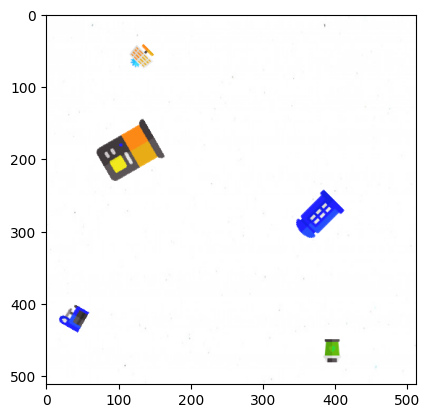

In [4]:
test_images.print(15)

In [5]:
def detect_on_dataset(
        test_imgs: ImageDataset, 
        query_imgs: ImageDataset, 
        sift_hps: Dict = {}, 
        lowe_threshold: float = 0.7,
        min_match_count: int = 10, 
        verbose: Verbosity = Verbosity.MEDIUM
    ) -> Tuple[float, ...]:

    acc_lst, tpr_list, fpr_lst, fnr_lst = [], [], [], []
    detector = ObjectDetector(query_imgs, sift_hps, verbose=False)

    # Iterate through each test image and detect objects in it. Compare these detctions to the ground truth annotations.
    for img, img_path in test_imgs:
        annotations_path = ANNOTATIONS_DIR / img_path.with_suffix(".csv").name
        img_annotations = pd.read_csv(annotations_path)

        print(f"Detecting objects in {img_path.stem}")
        detections = detector.detect(img, lowe_threshold, min_match_count, draw=False)
        acc, tpr, fpr, fnr = task3.evaluate_detections(detections, img_annotations)

        print(f"ACC: {acc:.2f}, TPR: {tpr:.2f}, FPR: {fpr:.2f}, FNR: {fnr:.2f}")
        acc_lst.append(acc)
        tpr_list.append(tpr)
        fpr_lst.append(fpr)
        fnr_lst.append(fnr)

    return np.mean(acc_lst), np.mean(tpr_list), np.mean(fpr_lst), np.mean(fnr_lst)

In [6]:
acc, tpr, fpr, fnr = detect_on_dataset(test_images, query_images)

Detecting objects in test_image_16
ACC: 0.25, TPR: 0.25, FPR: 0.00, FNR: 0.75
Detecting objects in test_image_19
ACC: 0.00, TPR: 0.00, FPR: 0.33, FNR: 1.00
Detecting objects in test_image_18
ACC: 0.00, TPR: 0.00, FPR: 0.00, FNR: 1.00
Detecting objects in test_image_12
ACC: 0.50, TPR: 0.50, FPR: 0.00, FNR: 0.50
Detecting objects in test_image_3
ACC: 0.25, TPR: 0.33, FPR: 0.25, FNR: 0.67
Detecting objects in test_image_4
ACC: 0.20, TPR: 0.25, FPR: 0.20, FNR: 0.75
Detecting objects in test_image_13
ACC: 0.25, TPR: 0.25, FPR: 0.00, FNR: 0.75
Detecting objects in test_image_6
ACC: 0.60, TPR: 0.75, FPR: 0.33, FNR: 0.25
Detecting objects in test_image_17
ACC: 0.00, TPR: 0.00, FPR: 0.20, FNR: 1.00
Detecting objects in test_image_2
ACC: 0.75, TPR: 1.00, FPR: 0.50, FNR: 0.00
Detecting objects in test_image_5
ACC: 0.40, TPR: 0.40, FPR: 0.00, FNR: 0.60
Detecting objects in test_image_15
ACC: 0.75, TPR: 0.75, FPR: 0.00, FNR: 0.25
Detecting objects in test_image_9
ACC: 0.25, TPR: 1.00, FPR: 0.50, FN

In [7]:
print("MEAN RESULTS:")
print(f"ACC: {acc:.2f}, TPR: {tpr:.2f}, FPR: {fpr:.2f}, FNR: {fnr:.2f}")

MEAN RESULTS:
ACC: 0.37, TPR: 0.49, FPR: 0.18, FNR: 0.51


MEAN RESULTS:
ACC: 0.34, TPR: 0.42, FPR: 0.20, FNR: 0.53